# Illegal zoning
_they made the character of our neighboorhoods illegal_

Waltham, like a lot of other cities with zoning codes, has a bit of a silly problem.
You see, the zoning is so restrictive in some places, that the existing structures could not be rebuilt.
Everything would have to go through a special permit, which is time consuming and expensive. You can imagine a lot of people
wouldn't even bother and just build where the zoning is easier.

What's the scale of the problem?

In [1]:
from dvc.api import DVCFileSystem
import pandas as pd
from io import BytesIO
import folium
import os
from zipfile import ZipFile
import geopandas as geo_pd
from dbfread import DBF
import sys
import pathlib
import seaborn as sns

%matplotlib inline

# constants
sys.path.append(pathlib.Path(os.getcwd()).parent.parent.as_posix())
from waltham.constants import SQ_FT_PER_ACRE

fs = DVCFileSystem("https://github.com/tjrileywisc/waltham_etl")

## Load shapefiles for buildings, zones, and parcels as well as the tax assessments data

In [2]:
with fs.open(f"data/gis/L3_SHP_M308_WALTHAM.zip") as f:
    content = BytesIO(f.read())
    zipfile = ZipFile(content)
    zipfile.extractall("../../data/gis")
    shp_path = f"../../data/gis/L3_SHP_M308_Waltham/M308TaxPar_CY22_FY23.shp"
    property_shapefiles_df = geo_pd.read_file(shp_path)
    # filter out right of way and water etc. property types
    property_shapefiles_df = property_shapefiles_df[property_shapefiles_df["POLY_TYPE"] == "FEE"]
    property_shapefiles_df = property_shapefiles_df[["LOC_ID", "geometry"]]

    assessments_table = DBF(f"../../data/gis/L3_SHP_M308_Waltham/M308Assess_CY22_FY23.dbf", load=True)

    assessments_df = pd.DataFrame([dict(r) for r in assessments_table.records])
    assessments_df = assessments_df[["LOC_ID", "SITE_ADDR", "LOT_SIZE", "YEAR_BUILT", "UNITS", "RES_AREA", "STORIES", "USE_CODE", "BLD_AREA"]]

### Data cleaning
See comments for reasoning

In [3]:

# bin YEAR_BUILT to 5 year intervals since this data was less accurate in the past
assessments_df["YEAR_BUILT"] = (assessments_df["YEAR_BUILT"] // 5).round().astype(int) * 5

# sliver parcels with invalid areas
assessments_df = assessments_df[~assessments_df["LOT_SIZE"].isna()]

# use codes should be ints, since they're grouped by hundreds typically
assessments_df["USE_CODE"] = assessments_df["USE_CODE"].astype(int)

In [4]:
assessments_df.head()

LOC_ID        SITE_ADDR  LOT_SIZE  YEAR_BUILT  UNITS  RES_AREA  \
0  F_734012_2963106  31  CLEMENTS RD      0.11        1930      1      1352   
1  F_730830_2973583     4  ABBOTT RD      0.22        1960      1      1931   
2  F_730659_2973534    15  ABBOTT RD      0.21        1950      1      1756   
3  F_730718_2973342    22  ABBOTT RD      0.23        1950      1      2922   
4  F_730548_2973294    33  ABBOTT RD      0.21        1950      1      1792   

  STORIES  USE_CODE  BLD_AREA  
0       2       101      1352  
1       1       101      1931  
2       2       101      1756  
3       2       101      2922  
4       2       101      1792

In [5]:
property_shapefiles_df.head()

LOC_ID                                           geometry
0  F_720118_2954451  POLYGON ((219510.406 900516.563, 219505.564 90...
1  F_720144_2954524  POLYGON ((219521.229 900544.743, 219512.577 90...
2  F_722474_2954539  POLYGON ((220212.276 900527.633, 220199.657 90...
3  F_720055_2954540  POLYGON ((219481.807 900560.359, 219483.941 90...
4  F_720183_2954604  POLYGON ((219530.434 900568.770, 219524.316 90...

In [6]:
shp_path = f"../../data/Buildings/Buildings.shp"
buildings_df = geo_pd.read_file(shp_path)
buildings_df = buildings_df[["geometry"]]

# assign MassGIS CRS
buildings_df.to_crs(property_shapefiles_df.crs, inplace=True)
buildings_df.head()

geometry
0  POLYGON ((219179.561 908215.757, 219174.404 90...
1  POLYGON ((219207.717 908210.616, 219205.988 90...
2  POLYGON ((219181.783 908206.625, 219176.641 90...
3  POLYGON ((219192.485 908186.819, 219192.235 90...
4  POLYGON ((219235.340 908191.010, 219235.404 90...

## The zoning rules table

This data comes from `Sec. 4.11. Table of Dimensional Regulations` of the city zoning code.

https://ecode360.com/attachment/WA1697/WA1697-Ze%20Table%20of%20Dimentional%20Regulations.pdf

I selected rows that apply to multi-family housing when the table had a more complex case defined per-use type.

Units are in feet for the most part, except for stories, FAR, lot coverage %, min open space % and max dwelling unit / acre values.

In [7]:
zoning_rules_df = pd.read_csv("../../data/zoning_rules_table.csv")
zoning_rules_df.set_index("District", inplace=True)
zoning_rules_df.head()

front setback  side setback  rear setback  height  stories  \
District                                                               
RA1                  40            20            40      35      2.5   
RA2                  40            20            40      35      2.5   
RA3                  25            15            30      35      2.5   
RA4                  25            15            30      35      2.5   
RB                   15            10            30      40      3.0   

          FAR by right  max lot coverage  min open space  lot area  max DUA  \
District                                                                      
RA1                NaN              0.20             NaN   20000.0      NaN   
RA2                NaN              0.20             NaN   15000.0      NaN   
RA3                NaN              0.25             NaN    9600.0      NaN   
RA4                NaN              0.25             NaN    7000.0      NaN   
RB                 NaN              0.30             NaN    6000.0      NaN   

          lot frontage  
District                
RA1                100  
RA2                 80  
RA3                 70  
RA4                 60  
RB                  60

In [8]:
with fs.open(f"data/gis/WalthamZoning.zip") as f:
    content = BytesIO(f.read())
    zipfile = ZipFile(content)
    zipfile.extractall("../../data/gis")
    shp_path = f"../../data/gis/WalthamZoning/WalthamZoning.shp"
    zoning_df = geo_pd.read_file(shp_path)

# set the waltham zoning crs to match the MassGIS one
zoning_df.to_crs(property_shapefiles_df.crs, inplace=True)

In [9]:
# assign existing parcels to zones
property_shapefiles_df["parcel_geometry"] = property_shapefiles_df["geometry"]
property_shapefiles_df["geometry"] = property_shapefiles_df.centroid
zoned_parcels_df = property_shapefiles_df.sjoin(zoning_df, how="left")
zoned_parcels_df.drop(axis="columns", labels=["index_right", "geometry"], inplace=True)
zoned_parcels_df.rename(columns={"NAME": "ZONE", "parcel_geometry": "geometry"}, inplace=True)
zoned_parcels_df = zoned_parcels_df[["LOC_ID", "geometry", "ZONE"]]

zoned_parcels_df = zoned_parcels_df[~zoned_parcels_df["ZONE"].isna()]

In [10]:
zoned_parcels_df.head(100)

LOC_ID                                           geometry ZONE
0    F_720118_2954451  POLYGON ((219510.406 900516.563, 219505.564 90...  RA3
1    F_720144_2954524  POLYGON ((219521.229 900544.743, 219512.577 90...  RA3
2    F_722474_2954539  POLYGON ((220212.276 900527.633, 220199.657 90...  RA3
3    F_720055_2954540  POLYGON ((219481.807 900560.359, 219483.941 90...  RA3
4    F_720183_2954604  POLYGON ((219530.434 900568.770, 219524.316 90...  RA3
..                ...                                                ...  ...
98   F_721106_2955606  POLYGON ((219836.030 900873.330, 219774.384 90...   RC
99   F_719877_2955687  POLYGON ((219440.509 900912.633, 219440.166 90...  RA3
100  F_722055_2955676  POLYGON ((220100.815 900877.988, 220073.624 90...  RA3
101  F_722277_2955700  POLYGON ((220134.904 900877.797, 220133.218 90...  RA3
102  F_720103_2955682  POLYGON ((219485.805 900872.219, 219481.976 90...  RA3

[100 rows x 3 columns]

In [11]:
# assign buildings to zones
zoned_buildings_df = buildings_df.sjoin(zoning_df, how="left", predicate="within")
zoned_buildings_df = zoned_buildings_df[["geometry", "NAME"]]
zoned_buildings_df.rename(columns={"NAME": "ZONE"}, inplace=True)
zoned_buildings_df.head()

geometry ZONE
0  POLYGON ((219179.561 908215.757, 219174.404 90...  RA2
1  POLYGON ((219207.717 908210.616, 219205.988 90...  RA2
2  POLYGON ((219181.783 908206.625, 219176.641 90...  RA2
3  POLYGON ((219192.485 908186.819, 219192.235 90...  RA2
4  POLYGON ((219235.340 908191.010, 219235.404 90...  RA2

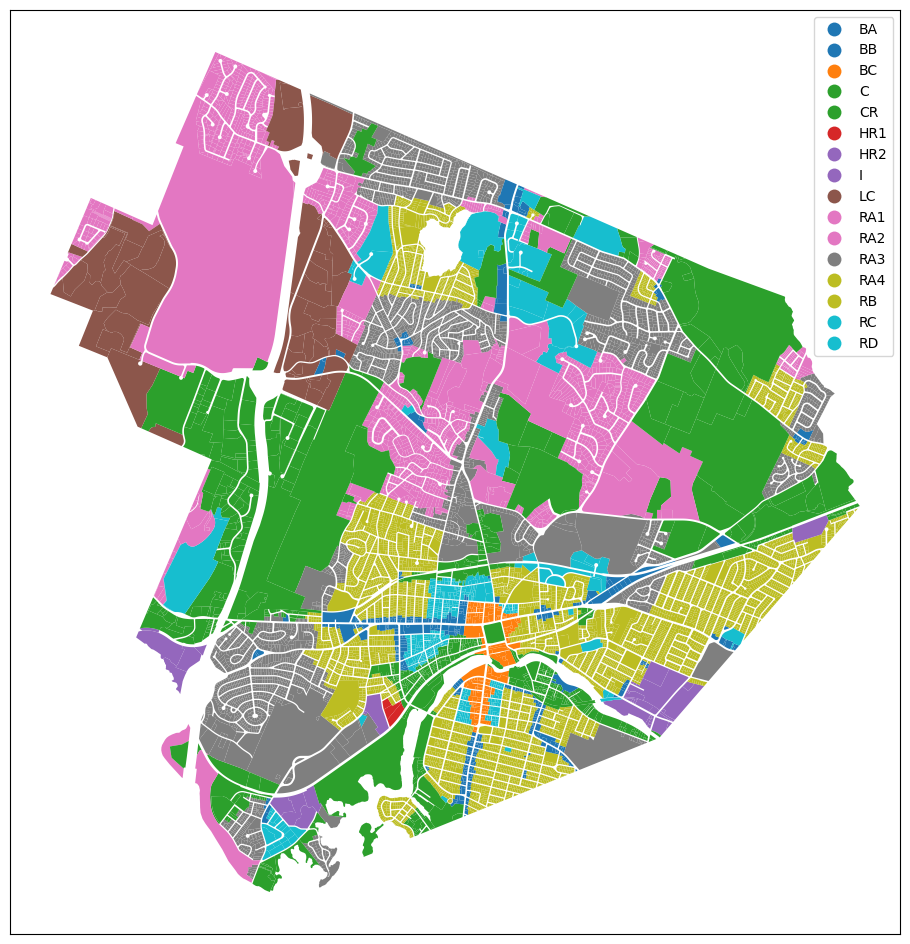

In [12]:
ax = zoned_parcels_df.plot(column="ZONE", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

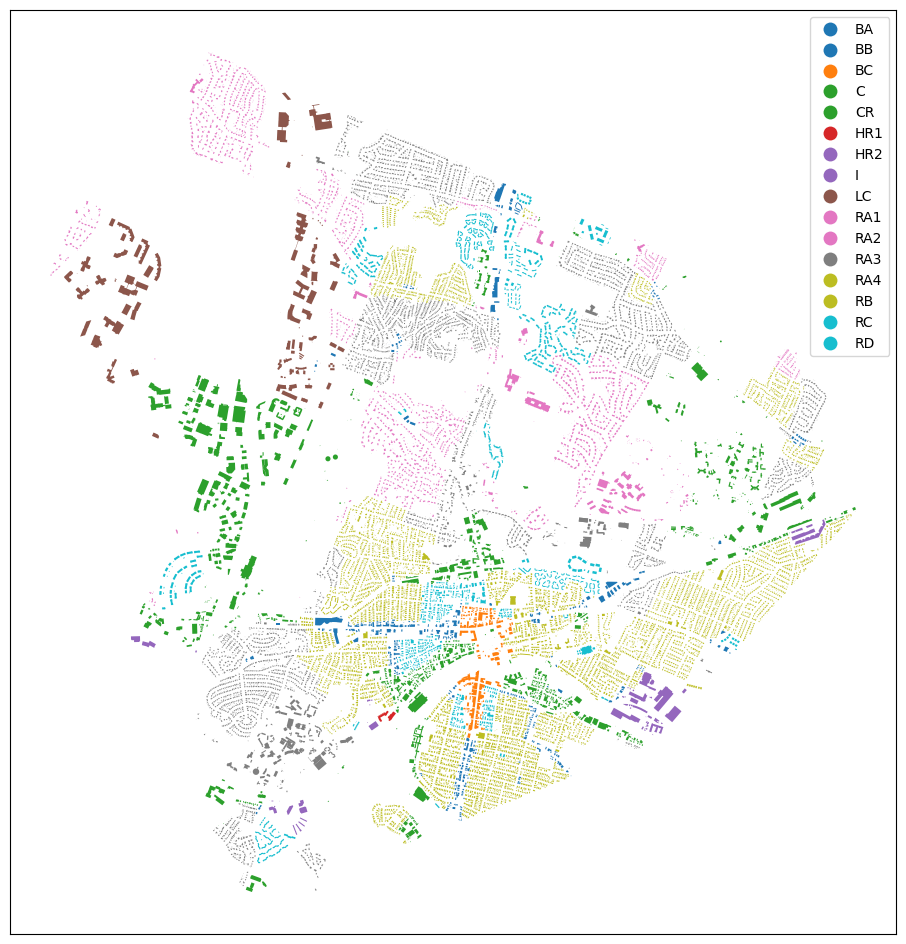

In [13]:
ax = zoned_buildings_df.plot(column="ZONE", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Non-compliance

Parcels might not comply if they're too small. Structures wouldn't comply based on their shape or closeness to each other. FAR and setback violations turn out to be pretty hard to calculate so we'll skip that for now.

In [14]:
zoned_parcels_df = zoned_parcels_df.merge(assessments_df, how="inner", on=["LOC_ID"])

In [15]:
zoned_parcels_df.head()

LOC_ID                                           geometry ZONE  \
0  F_720118_2954451  POLYGON ((219510.406 900516.563, 219505.564 90...  RA3   
1  F_720144_2954524  POLYGON ((219521.229 900544.743, 219512.577 90...  RA3   
2  F_722474_2954539  POLYGON ((220212.276 900527.633, 220199.657 90...  RA3   
3  F_720055_2954540  POLYGON ((219481.807 900560.359, 219483.941 90...  RA3   
4  F_720183_2954604  POLYGON ((219530.434 900568.770, 219524.316 90...  RA3   

             SITE_ADDR  LOT_SIZE  YEAR_BUILT  UNITS  RES_AREA STORIES  \
0        759  SOUTH ST      0.15        1975      1      1612       2   
1     753 -55 SOUTH ST      0.22        1860      2      5678       3   
2  72 LOT EDGEWATER DR      0.11           0      0         0           
3        757  SOUTH ST      0.35        1975      1       960       1   
4        749  SOUTH ST      0.15        1960      1      1517       2   

   USE_CODE  BLD_AREA  
0       101      1612  
1       104      5678  
2       132         0  
3       101       960  
4       101      1517

In [16]:
zoning_rules_df.head(25)

front setback  side setback  rear setback  height  stories  \
District                                                               
RA1                  40            20            40      35      2.5   
RA2                  40            20            40      35      2.5   
RA3                  25            15            30      35      2.5   
RA4                  25            15            30      35      2.5   
RB                   15            10            30      40      3.0   
RC                   10            10            20      40      3.0   
RD                   75            45            60      50      4.0   
HR1                  10            10            10      74      6.0   
HR2                  10            10            20      74      6.0   
BA                   10             0            15      36      3.0   
BB                    0             0            25      48      4.0   
BC                    0             0            25      65      5.0   
LC                  150           100           100      40      3.0   
C                    10            15            25      80      8.0   
I                    10            15            25      80      8.0   
CR                  100           100           100      20      1.0   

          FAR by right  max lot coverage  min open space  lot area  max DUA  \
District                                                                      
RA1                NaN              0.20             NaN   20000.0      NaN   
RA2                NaN              0.20             NaN   15000.0      NaN   
RA3                NaN              0.25             NaN    9600.0      NaN   
RA4                NaN              0.25             NaN    7000.0      NaN   
RB                 NaN              0.30             NaN    6000.0      NaN   
RC                0.20              0.30            0.15    6000.0      6.0   
RD                0.20              0.30            0.15  217800.0      6.0   
HR1               1.80              0.75             NaN   10000.0     59.0   
HR2               0.01              0.75             NaN   10000.0      3.0   
BA                0.20              0.30            0.15    6000.0      6.0   
BB                0.25              0.35            0.15    6000.0     10.0   
BC                1.00              0.90             NaN       NaN     30.0   
LC                0.25              0.30            0.25  217800.0      NaN   
C                 0.40               NaN             NaN   10000.0      NaN   
I                 0.40               NaN             NaN       0.0      NaN   
CR                0.05              0.05            0.10  174240.0      0.0   

          lot frontage  
District                
RA1                100  
RA2                 80  
RA3                 70  
RA4                 60  
RB                  60  
RC                  50  
RD                  50  
HR1                 50  
HR2                 50  
BA                  50  
BB                  50  
BC                  40  
LC                 400  
C                   50  
I                   50  
CR                 100

### Parcel size

Some zones have a minimum parcel size requirement.

In [17]:
def parcel_size(row):
    """
    returns True if the
    parcel is too small,
    False if there's no requirement
    or parcel is large enough
    """
    zone = row["ZONE"]
    min_lot_size = zoning_rules_df.at[zone, "lot area"]

    # no requirement for this parcel or parcel is somehow
    # zero size
    if min_lot_size == float('nan'):
        return False
    elif row["LOT_SIZE"] == float('nan') or row["LOT_SIZE"] == 0:
        return False
    
    return (row["LOT_SIZE"] * SQ_FT_PER_ACRE < min_lot_size)

zoned_parcels_df["parcel_size"] = zoned_parcels_df.apply(lambda row: parcel_size(row), axis=1)

In [18]:
zoned_parcels_df["parcel_size"].value_counts()

parcel_size
False    9445
True     7063
Name: count, dtype: int64

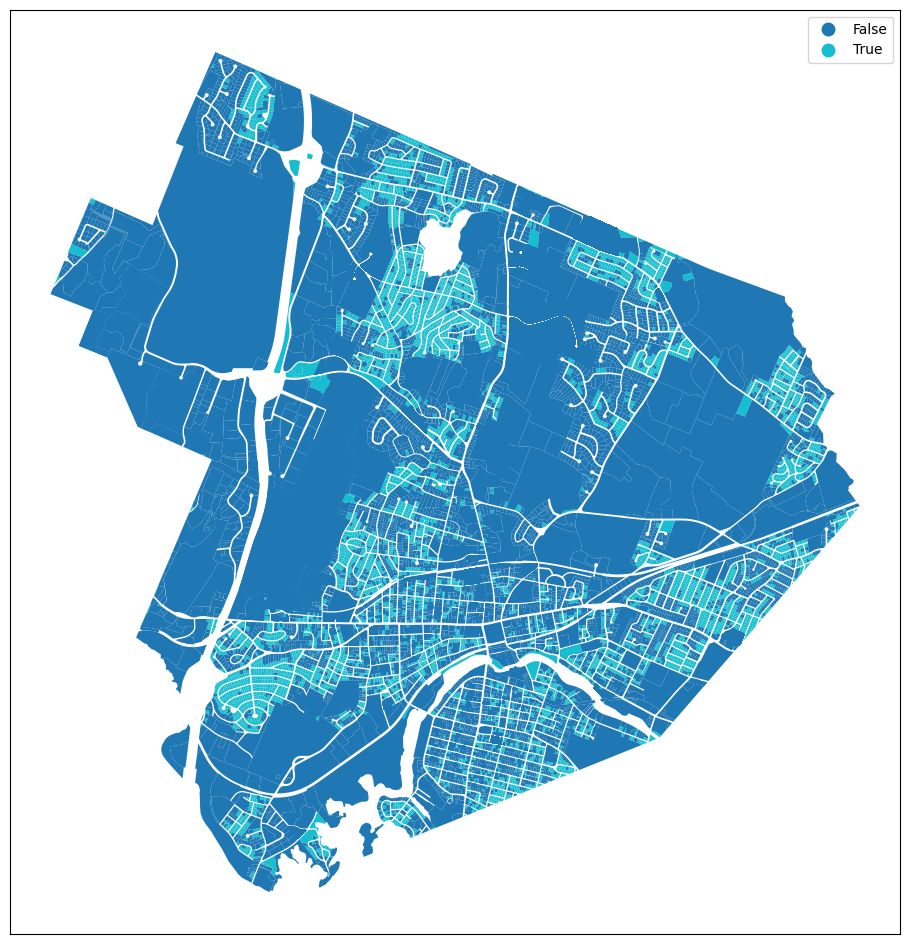

In [19]:
ax = zoned_parcels_df.plot(column="parcel_size", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

leg = ax.get_legend()

### Too many stories

Because there's a shadow on my cucumber garden at 6:50 am in November

In [20]:
def stories_high(row):
    """
    returns True if the
    structure on the parcel
    has too many stories,
    False if there's no requirement
    """
    zone = row["ZONE"]
    stories = zoning_rules_df.at[zone, "stories"]

    # no requirement for this parcel or parcel is somehow
    # zero size
    if stories == float('nan') or stories == "":
        return False
    elif row["STORIES"] == float('nan') or row["STORIES"] == "":
        return False

    return (float(row["STORIES"]) > float(stories))

zoned_parcels_df["stories_high"] = zoned_parcels_df.apply(lambda row: stories_high(row), axis=1)

In [21]:
zoned_parcels_df["stories_high"].value_counts()

stories_high
False    16268
True       240
Name: count, dtype: int64

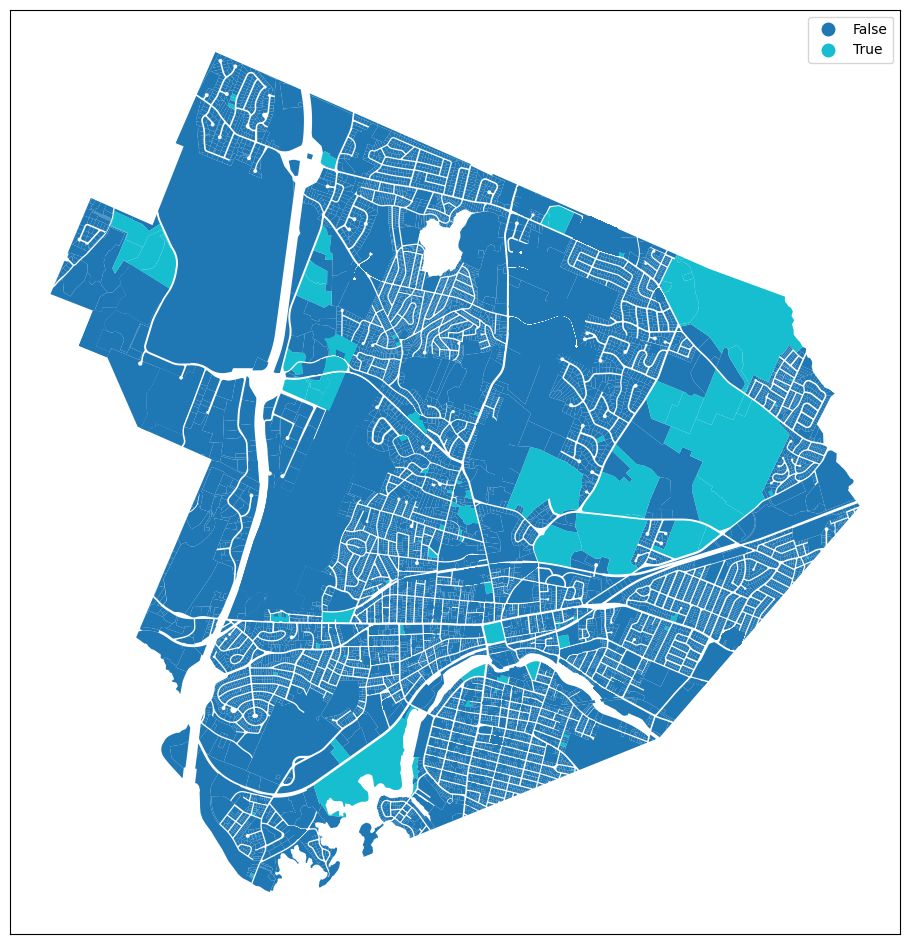

In [22]:
ax = zoned_parcels_df.plot(column="stories_high", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

leg = ax.get_legend()

### Dwelling units per acre too high
Too many housing units in an acre

In [23]:
zoned_parcels_df[zoned_parcels_df["USE_CODE"].isna()]

Empty GeoDataFrame
Columns: [LOC_ID, geometry, ZONE, SITE_ADDR, LOT_SIZE, YEAR_BUILT, UNITS, RES_AREA, STORIES, USE_CODE, BLD_AREA, parcel_size, stories_high]
Index: []

In [24]:
def too_many_units_per_acre(row):
    """
    returns True if the parcel has
    too many units / acre, for
    residential use codes
    """

    # residential use codes
    if int(row["USE_CODE"]) not in range(100, 200):
        return False

    zone = row["ZONE"]
    max_dua = zoning_rules_df.at[zone, "max DUA"]
    as_built_units = row["UNITS"]
    lot_size = row["LOT_SIZE"]

    # no requirement for this parcel or parcel is somehow
    # zero size
    if pd.isna(max_dua) or max_dua == "":
        return False
    elif as_built_units == float('nan') or as_built_units == "" or lot_size == 0:
        return False

    return as_built_units / lot_size > max_dua

zoned_parcels_df["too_many_units_per_acre"] = zoned_parcels_df.apply(lambda row: too_many_units_per_acre(row), axis=1)

In [25]:
zoned_parcels_df["too_many_units_per_acre"].value_counts()

too_many_units_per_acre
False    15975
True       533
Name: count, dtype: int64

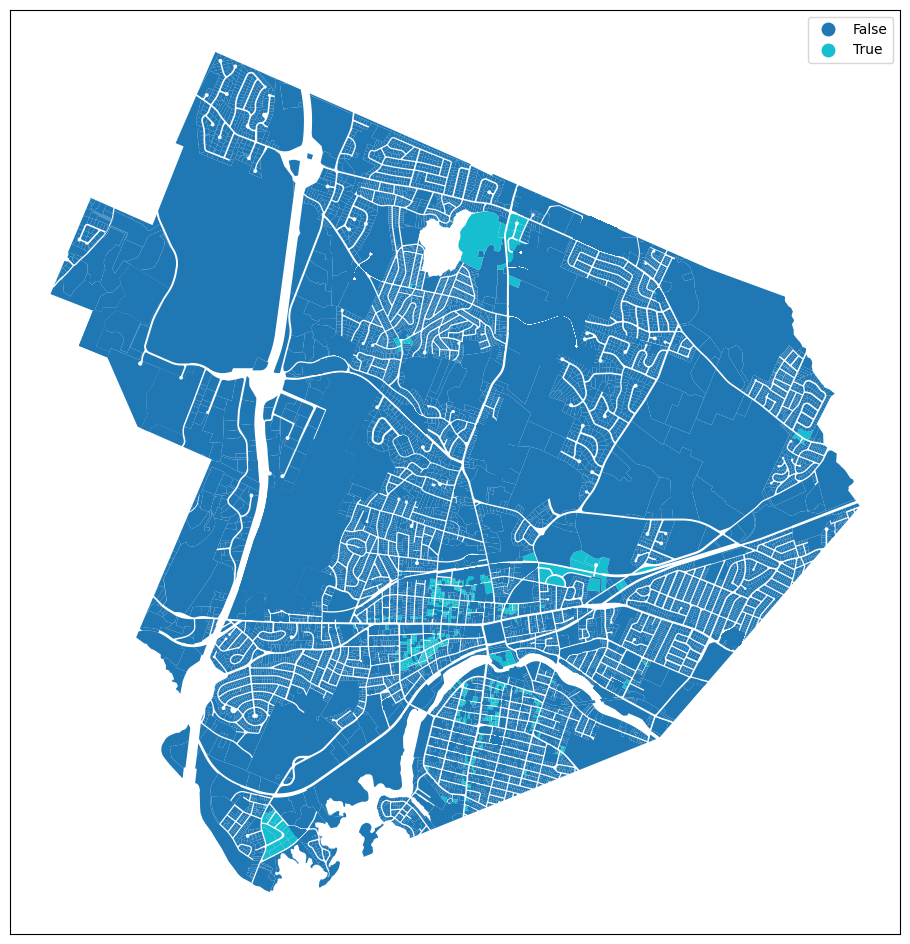

In [26]:
ax = zoned_parcels_df.plot(column="too_many_units_per_acre", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

leg = ax.get_legend()

### Max lot coverage violations

IT'S A MONSTROSITY

I'm not too sure I have this correct, based on the interpretation of 'BLD_AREA'. Is it the sum total area (so adding the floors), or just the building footprint?

In [27]:
def lot_coverage_too_high(row):
    """
    returns True if the lot coverage
    of the built structure is
    higher than allowed
    """


    zone = row["ZONE"]
    max_lot_coverage = zoning_rules_df.at[zone, "max lot coverage"]
    bld_area = row["BLD_AREA"]
    lot_size = row["LOT_SIZE"]

    if pd.isna(max_lot_coverage) or max_lot_coverage == "":
        return False
    elif bld_area == float('nan') or bld_area == "":
        return False

    return bld_area > (lot_size * SQ_FT_PER_ACRE)

zoned_parcels_df["lot_coverage_too_high"] = zoned_parcels_df.apply(lambda row: lot_coverage_too_high(row), axis=1)

In [28]:
zoned_parcels_df["lot_coverage_too_high"].value_counts()

lot_coverage_too_high
False    12671
True      3837
Name: count, dtype: int64

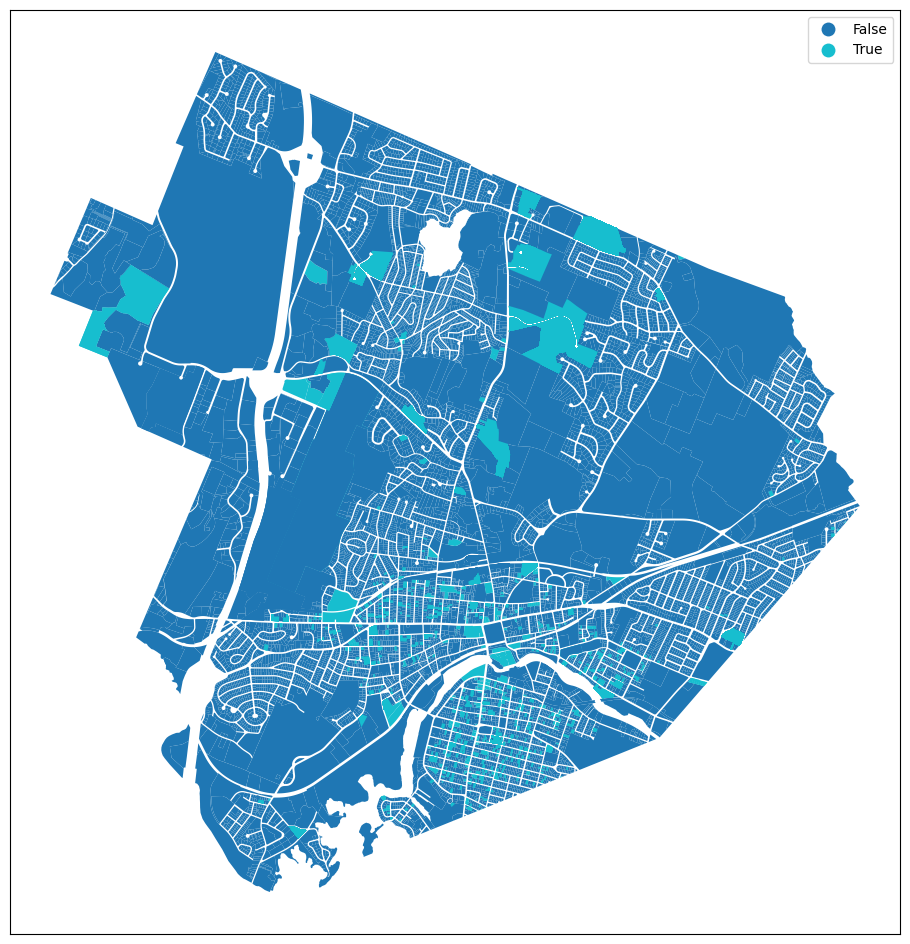

In [29]:
ax = zoned_parcels_df.plot(column="lot_coverage_too_high", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

leg = ax.get_legend()

### FAR violations

(floor area ratio, another way to discourage massing for some reason)

I'm not so sure I have this correct either.

In [30]:
def far_high(row):
    """
    returns True if the lot coverage
    of the built structure is
    higher than allowed
    """


    zone = row["ZONE"]
    far_limit = zoning_rules_df.at[zone, "FAR by right"]
    bld_area = row["BLD_AREA"]
    stories = row["STORIES"]
    lot_size = row["LOT_SIZE"] * SQ_FT_PER_ACRE

    if pd.isna(far_limit) or far_limit in["", 0] or lot_size == 0:
        return {"far_high": False, "far": 0.0}
    elif bld_area in [float('nan'), ""] or stories in [float('nan'), ""]:
        return {"far_high": False, "far": 0.0}

    far = (bld_area * float(stories) / lot_size)
    
    return {"far_high": far > far_limit, "far": far}

#zoned_parcels_df["far"] = 0.0
zoned_parcels_df[["far_high", "far"]] = zoned_parcels_df.apply(lambda row: far_high(row), axis='columns', result_type='expand')

In [31]:
zoned_parcels_df["far_high"].value_counts()

far_high
False    15217
True      1291
Name: count, dtype: int64

<Axes: xlabel='far', ylabel='Count'>

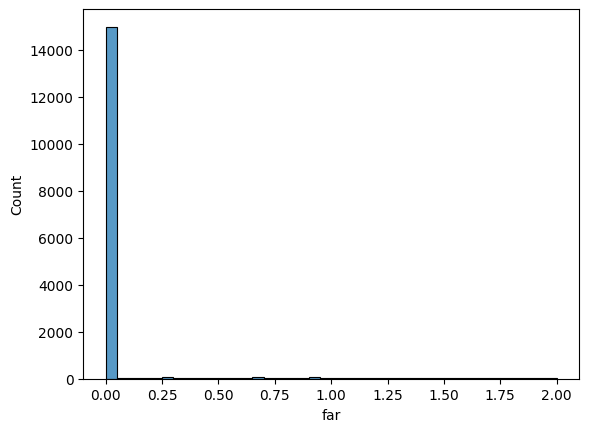

In [32]:
sns.histplot(zoned_parcels_df["far"], binrange=[0.0, 2.0], binwidth=0.05)

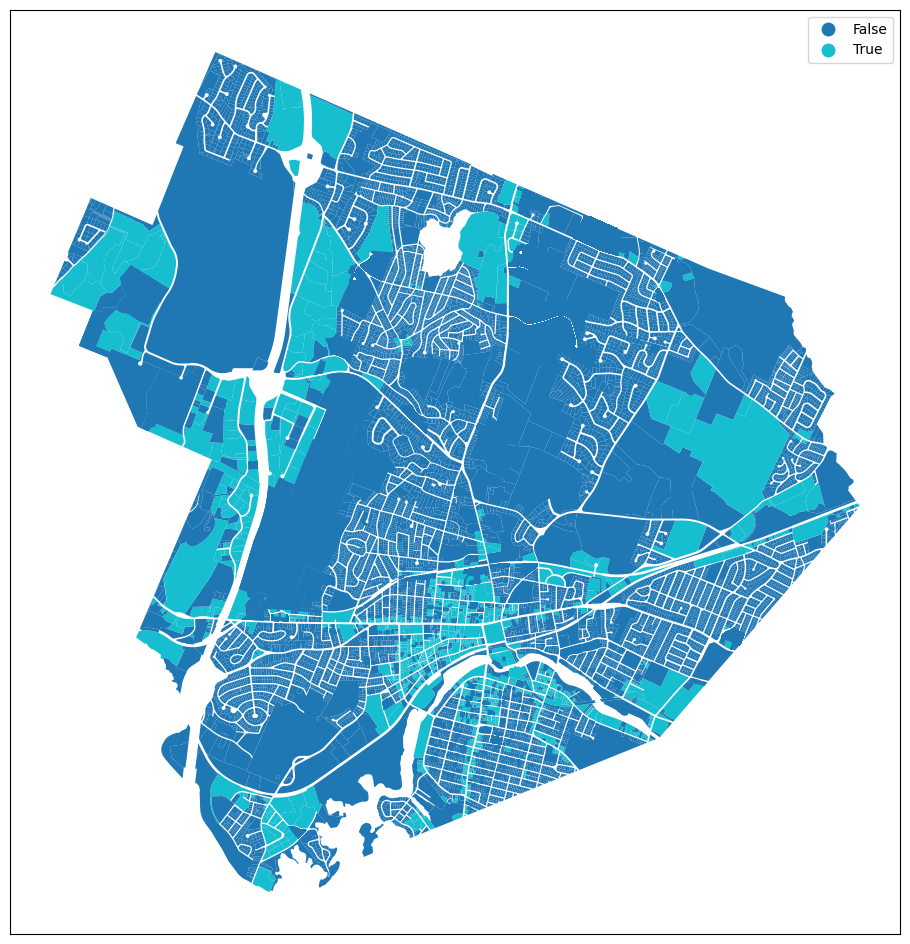

In [33]:
ax = zoned_parcels_df.plot(column="far_high", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## All parcels that are illegal
(any combination of zoning violations)

In [34]:
zoned_parcels_df.columns

Index(['LOC_ID', 'geometry', 'ZONE', 'SITE_ADDR', 'LOT_SIZE', 'YEAR_BUILT',
       'UNITS', 'RES_AREA', 'STORIES', 'USE_CODE', 'BLD_AREA', 'parcel_size',
       'stories_high', 'too_many_units_per_acre', 'lot_coverage_too_high',
       'far_high', 'far'],
      dtype='object')

In [35]:
def any_violations(row):
    "returns True for any violation"
    
    return row["parcel_size"] or row["stories_high"] or row["too_many_units_per_acre"] or row["lot_coverage_too_high"] or row["far_high"]

zoned_parcels_df["any_violations"] = zoned_parcels_df.apply(lambda row: any_violations(row), axis=1)

In [36]:
zoned_parcels_df["any_violations"].value_counts()

any_violations
True     11525
False     4983
Name: count, dtype: int64

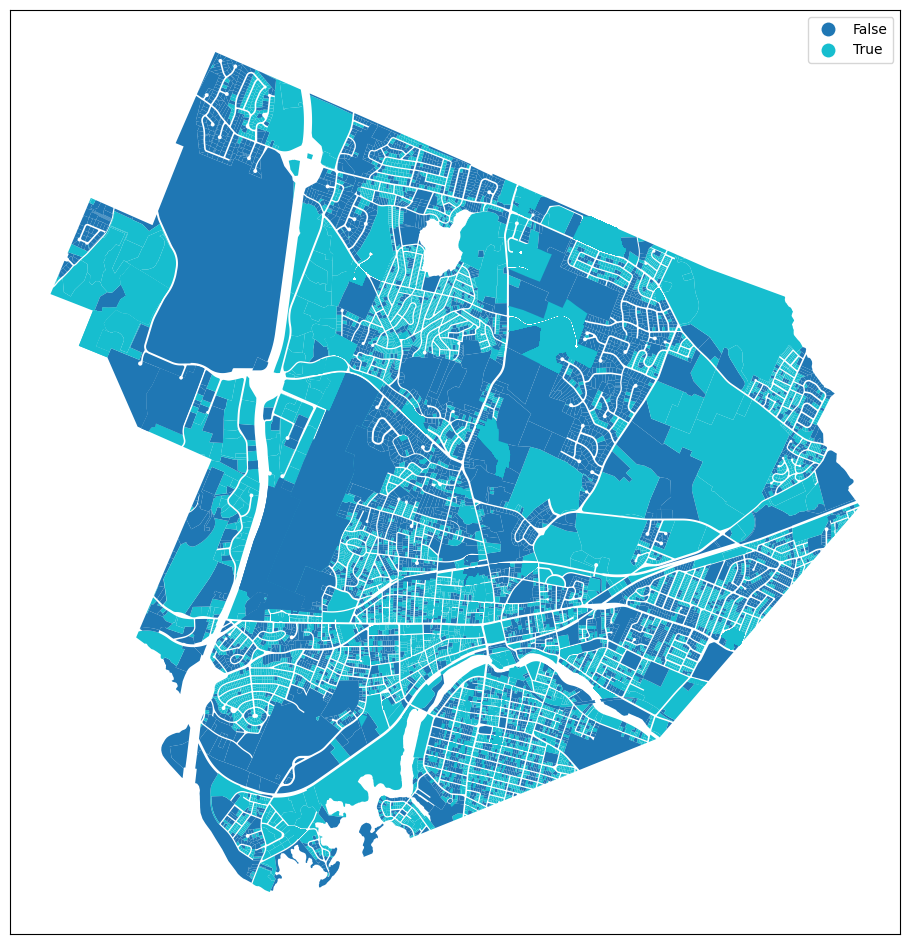

In [37]:
ax = zoned_parcels_df.plot(column="any_violations", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


#### Violations by year built

What is the real character of the city? The older structures, or the newer ones?
Of course you would expect that newer structures would be more likely to be acceptable (since that was the whole point of the zoning),
but if you didn't have any bias against the older stock, you would have incorporated into the zoning code.

<Axes: xlabel='YEAR_BUILT', ylabel='any_violations'>

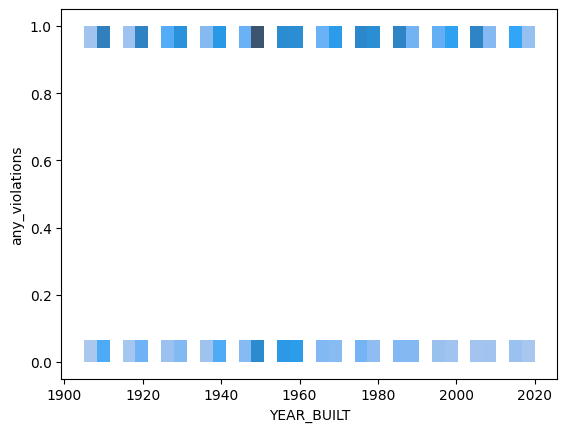

In [38]:
sns.histplot(zoned_parcels_df[zoned_parcels_df["YEAR_BUILT"] > 1900], x="YEAR_BUILT", y="any_violations")

Text(0.5, 1.0, 'parcels with at least one violation')

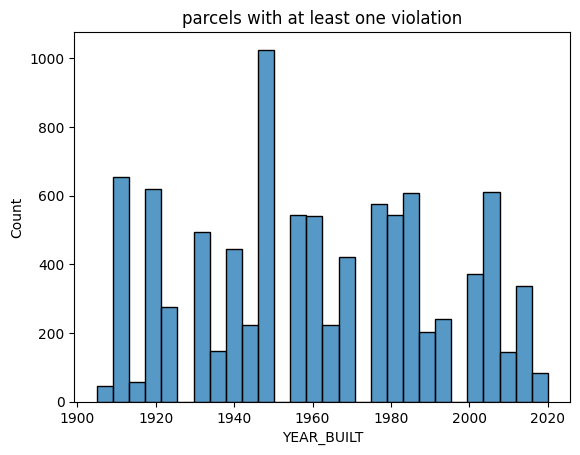

In [39]:
ax = sns.histplot(
    zoned_parcels_df[
        (zoned_parcels_df["YEAR_BUILT"] > 1900) & (zoned_parcels_df["any_violations"])
    ], 
    x="YEAR_BUILT"
)

ax.set_title("parcels with at least one violation")

Text(0.5, 1.0, 'parcels without violations')

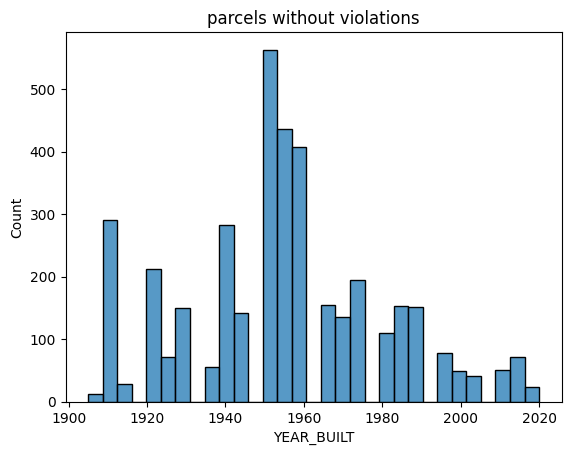

In [40]:
ax = sns.histplot(
    zoned_parcels_df[
        (zoned_parcels_df["YEAR_BUILT"] > 1900) & (~zoned_parcels_df["any_violations"])
    ], 
    x="YEAR_BUILT"
)

ax.set_title("parcels without violations")

#### Violations weighted by units built (i.e. units in parcels that have residential uses)

Not sure if I'm capturing this the best way. Seaborn doesn't let you weight 2d histograms (or I haven't yet figured out how), so I made a record for every unit. It doesn't
quite separate SFH from MFH though in this view.

<Axes: xlabel='YEAR_BUILT', ylabel='any_violations'>

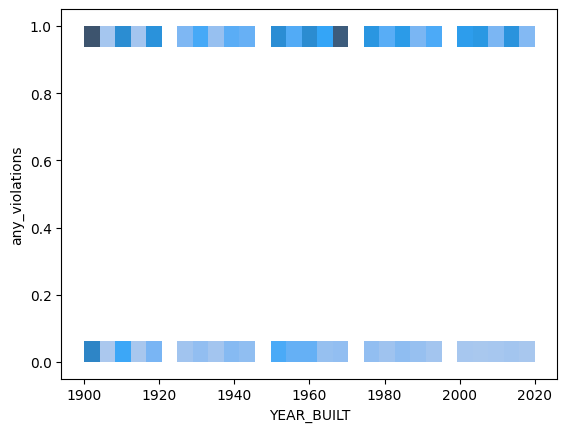

In [41]:
# there must be a better way to do this

units_weighted = []
for index in range(len(zoned_parcels_df)):
    if int(zoned_parcels_df.at[index, "USE_CODE"]) > 200 or int(zoned_parcels_df.at[index, "YEAR_BUILT"]) < 1900:
        continue
    
    for _ in range(zoned_parcels_df.at[index, "UNITS"]):
        units_weighted.append({
            "YEAR_BUILT": zoned_parcels_df.at[index, "YEAR_BUILT"],
            "any_violations": zoned_parcels_df.at[index, "any_violations"]
        })

df = pd.DataFrame(units_weighted)

sns.histplot(
    df,
    x="YEAR_BUILT",
    y="any_violations"
)

Text(0.5, 1.0, 'units in parcels with violations')

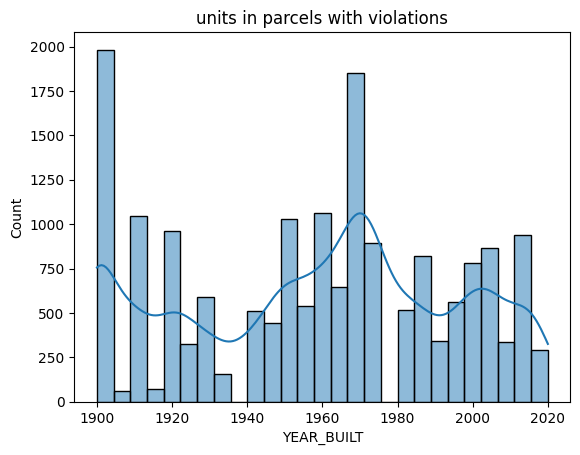

In [42]:
ax = sns.histplot(
    df[df["any_violations"]], 
    x="YEAR_BUILT",
    kde=True
)

ax.set_title("units in parcels with violations")

Text(0.5, 1.0, 'units in parcels without violations')

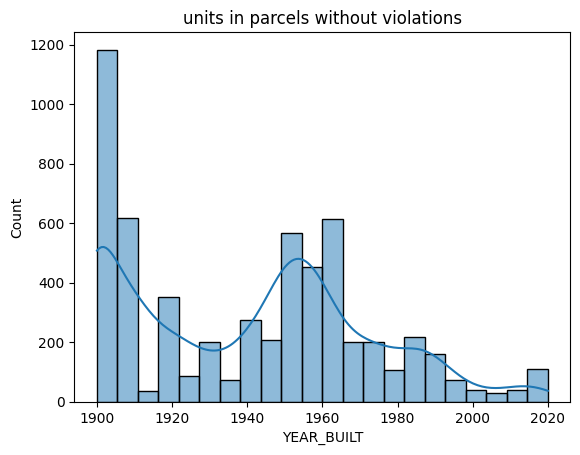

In [43]:
ax = sns.histplot(
    df[~df["any_violations"]], 
    x="YEAR_BUILT",
    kde=True
)

ax.set_title("units in parcels without violations")

In [44]:
zoned_parcels_df.columns

Index(['LOC_ID', 'geometry', 'ZONE', 'SITE_ADDR', 'LOT_SIZE', 'YEAR_BUILT',
       'UNITS', 'RES_AREA', 'STORIES', 'USE_CODE', 'BLD_AREA', 'parcel_size',
       'stories_high', 'too_many_units_per_acre', 'lot_coverage_too_high',
       'far_high', 'far', 'any_violations'],
      dtype='object')

In [45]:
#zoned_parcels_df.to_file("derived/illegal_zoning.shp")

In [46]:
# prepare for mapping by converting to a lat/lon CRS
zoned_parcels_df.to_crs("EPSG:4326", inplace=True)

In [47]:
center = [42.3, -71.2]
bounds = zoned_parcels_df.total_bounds.tolist()
m = folium.Map(
    location=center,
    zoom_start=10,
    tiles="cartodbpositron"
)

m.fit_bounds([bounds[:2][::-1], bounds[2:][::-1]])

tooltip = folium.GeoJsonTooltip(
    fields=["SITE_ADDR", "parcel_size", "stories_high", "too_many_units_per_acre", "lot_coverage_too_high", "far_high"],
    aliases=["SITE_ADDR", "parcel_size", "stories_high", "too_many_units_per_acre", "lot_coverage_too_high", "far_high"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

def fill_rule(feature):
    return {
        "fillColor": "red"
        if feature["properties"]["any_violations"] == 1
        else "green",
        "color": "black",
        "weight": 2,
        "fillOpacity": 0.2
    }

folium.GeoJson(
    zoned_parcels_df,
    style_function=lambda feature: fill_rule(feature),
    tooltip=tooltip
).add_to(m)


In [48]:

# uncomment to show - usually makes the file too big to show in github though
#m

In [49]:
os.makedirs("html", exist_ok=True)
m.save("html/illegal_zoning.html", bounds=(bounds[:2][::-1] + bounds[2:][::-1]))